# 🎯 目標三：數位資源差異與學習投入關聯分析（含時間轉換）

本 Notebook 探討家庭 SES、數位資源近用品質、使用模式與學習表現間的關聯，並處理原始時間型文字為數值，適用於 as35 系列變項。

## 📥 載入學生、家長、學校資料

In [18]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# 載入資料（請確認檔案與 Notebook 同一資料夾）
df_s = pd.read_csv("../data/TIGPSw1_s_descriptive_labeled.csv")
df_p = pd.read_csv("../data/TIGPSw1_p_descriptive_labeled.csv")
df_sc = pd.read_csv("../data/TIGPSw1_sc_descriptive_labeled.csv")

print(df_s.shape, df_p.shape, df_sc.shape)


C:\Users\user\AppData\Local\Temp\ipykernel_7404\2667815177.py:5: DtypeWarning: Columns (7,19,29,152,368,383,483,507,529,577,579,603,627) have mixed types. Specify dtype option on import or set low_memory=False.
  df_s = pd.read_csv("../data/TIGPSw1_s_descriptive_labeled.csv")


(8958, 688) (4495, 563) (175, 138)


C:\Users\user\AppData\Local\Temp\ipykernel_7404\2667815177.py:6: DtypeWarning: Columns (16,18,34,262,281,291,451,473,482,484,499,561) have mixed types. Specify dtype option on import or set low_memory=False.
  df_p = pd.read_csv("../data/TIGPSw1_p_descriptive_labeled.csv")


## 🔗 合併資料（依學生 ID 與學校 ID）

In [19]:
# 確保不重複合併 '學校 ID' 欄位
df_p_filtered = df_p.drop(columns=['學校 ID'], errors='ignore')
df = df_s.merge(df_p_filtered, on='學生 ID', how='left')
df = df.merge(df_sc, on='學校 ID', how='left')
import pandas as pd

# 指定家境順序（從很不富裕到很富裕）
family_order = ['很不富裕', '不富裕', '經濟普通', '富裕', '很富裕']

# 建立有順序的類別型別
family_dtype = CategoricalDtype(categories=family_order, ordered=True)

# 指定順序（不移除任何值）
df['請問您認為家裡的經濟狀況為何？'] = df['請問您認為家裡的經濟狀況為何？'].astype(family_dtype)

grade_order = [
    '全班五名以內',
    '全班六至十名',
    '全班十一至二十名',
    '全班二十一至三十名',
    '全班三十名以後'
]

grade_dtype = pd.CategoricalDtype(categories=grade_order, ordered=True)

# 假設欄位名稱是「你上學期的平均成績大約如何？」
df['你上學期的平均成績大約如何?'] = df['你上學期的平均成績大約如何?'].replace(
    ['我不知道', '系統遺漏值', '此卷未答'], pd.NA
)
df['你上學期的平均成績大約如何?'] = df['你上學期的平均成績大約如何?'].astype(grade_dtype)
print(df.shape)


(10008, 1386)


## ⏱️ 文字時間轉換為數值：as35 系列

In [20]:
time_mapping = {
    "沒有": 0.0, "0.5小時以內": 0.25, "0.5-1小時": 0.75, "1-1.5小時": 1.25,
    "1.5-2小時": 1.75, "2-2.5小時": 2.25, "2.5-3小時": 2.75, "3-3.5小時": 3.25,
    "3.5-4小時": 3.75, "4-4.5小時": 4.25, "4.5-5小時": 4.75, "5小時以上": 5.5
}

time_cols = [
    "完成學校功課(查找完成作業需要的資料)",
    "課外的學習(各種線上付費或免費的課程)",
    "玩線上遊戲",
    "看影片、聽音樂、迷因梗圖、卡通、漫畫",
    "和他人聊天(傳訊息)"
]

for col in time_cols:
    df[col + "_num"] = df[col].map(time_mapping)

df['total_time'] = df[[c + "_num" for c in time_cols]].sum(axis=1)

df['study_ratio'] = (
    df["完成學校功課(查找完成作業需要的資料)_num"] +
    df["課外的學習(各種線上付費或免費的課程)_num"]
) / df['total_time']

df['entertainment_ratio'] = (
    df["玩線上遊戲_num"] +
    df["看影片、聽音樂、迷因梗圖、卡通、漫畫_num"] +
    df["和他人聊天(傳訊息)_num"]
) / df['total_time']


## 📊 敘述統計：數位資源、SES、自評家境與使用時間

In [21]:
print("數位資源品質：")
print(df[['對我來說,要購買3C產品(手機、電腦、平板)的費用太高。', '我住的地方沒有網路訊號或是訊號太弱。', '對我來說,使用網路要付的費用太貴。', '對我來說,很難找到一個不受干擾的空間來上網。']].describe(include='all'))

print("\nSES：")
print(df[['請問您的學歷', '請問您認為家裡的經濟狀況為何？']].value_counts())

print("\n學習時間比例")
print(df[['study_ratio', 'entertainment_ratio']].describe())

from scipy.stats import spearmanr, kendalltau
# 1. 定義欄位
digital_quality_cols = [
    '對我來說,要購買3C產品(手機、電腦、平板)的費用太高。',
    '我住的地方沒有網路訊號或是訊號太弱。',
    '對我來說,使用網路要付的費用太貴。',
    '對我來說,很難找到一個不受干擾的空間來上網。'
]
study_cols = ['study_ratio', 'entertainment_ratio']

# 2. 擷取分析用的資料
df_corr = df[digital_quality_cols + study_cols].copy()

# 3. Spearman 與 Kendall 分析
for dq_col in digital_quality_cols:
    for study_col in study_cols:
        # 先移除缺漏值
        temp_df = df_corr[[dq_col, study_col]].dropna()
        
        # 計算 Spearman
        rho, p_spearman = spearmanr(temp_df[dq_col], temp_df[study_col])
        
        # 計算 Kendall
        tau, p_kendall = kendalltau(temp_df[dq_col], temp_df[study_col])

        # 輸出結果
        print(f"\n=== 數位資源品質：{dq_col} × {study_col} ===")
        print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
        print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")


數位資源品質：
       對我來說,要購買3C產品(手機、電腦、平板)的費用太高。 我住的地方沒有網路訊號或是訊號太弱。 對我來說,使用網路要付的費用太貴。  \
count                         10008              10008             10008   
unique                            6                  6                 6   
top                            此卷未答               此卷未答              此卷未答   
freq                           4674               4674              4674   

       對我來說,很難找到一個不受干擾的空間來上網。  
count                   10008  
unique                      6  
top                      此卷未答  
freq                     4674  

SES：
請問您的學歷    請問您認為家裡的經濟狀況為何？
大學、二技、四技  富裕                 960
五專、二專     富裕                 467
碩士        富裕                 462
高中職       富裕                 451
國（初）中     富裕                  44
博士        富裕                  43
大學、二技、四技  很富裕                 18
小學        富裕                  14
高中職       很富裕                 14
碩士        很富裕                  5
五專、二專     很富裕                  5
無／不識字     富裕                   4
博士        很富裕          

## 🧮 SES 與網路品質 (as57b) 關聯

=== Spearman 等級相關係數 ===
Spearman ρ = nan, p-value = nan

=== Kendall 等級相關係數 ===
Kendall τ = nan, p-value = nan


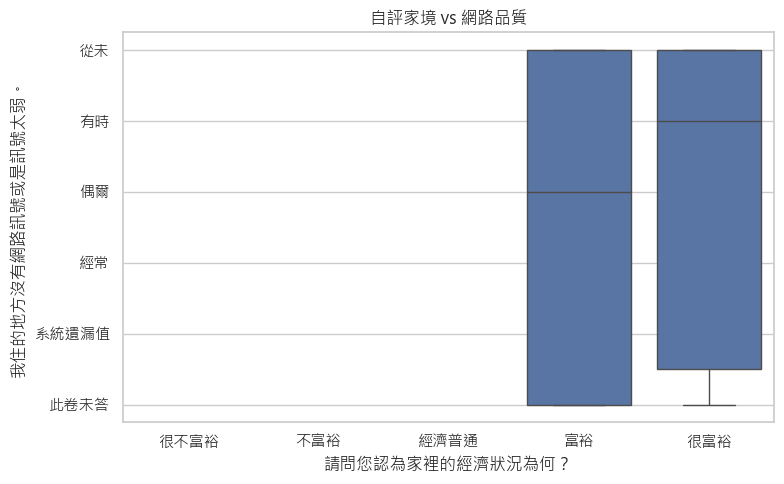

In [22]:
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# 設定中文字體與樣式
sns.set(font="Microsoft JhengHei", style="whitegrid")

# === 把「經濟狀況」轉換成數值（愈好數值愈高） ===
# 請根據你實際的經濟狀況選項順序調整 mapping
economic_map = {
    "非常不好": 1,
    "不好": 2,
    "普通": 3,
    "好": 4,
    "非常好": 5
}

# 建立新資料欄
df_corr = df[['請問您認為家裡的經濟狀況為何？', '我住的地方沒有網路訊號或是訊號太弱。']].dropna().copy()
df_corr['經濟狀況_數值'] = df_corr['請問您認為家裡的經濟狀況為何？'].map(economic_map)
df_corr['網路品質'] = df_corr['我住的地方沒有網路訊號或是訊號太弱。']  # 假設已是數值（Likert）

# === 等級相關分析 ===
rho, p_spearman = spearmanr(df_corr['經濟狀況_數值'], df_corr['網路品質'])
tau, p_kendall = kendalltau(df_corr['經濟狀況_數值'], df_corr['網路品質'])

# === 顯示結果 ===
print("=== Spearman 等級相關係數 ===")
print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")

print("\n=== Kendall 等級相關係數 ===")
print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")

# === 繪圖 ===
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='請問您認為家裡的經濟狀況為何？', y='我住的地方沒有網路訊號或是訊號太弱。')
plt.title('自評家境 vs 網路品質')
plt.tight_layout()
plt.show()

## 🔁 SES vs 使用模式比例相關性

In [23]:
print(df[['請問您認為家裡的經濟狀況為何？', 'study_ratio']].corr(numeric_only=True))


             study_ratio
study_ratio          1.0


## 📈 使用比例或網路品質 vs 成績 (as20)

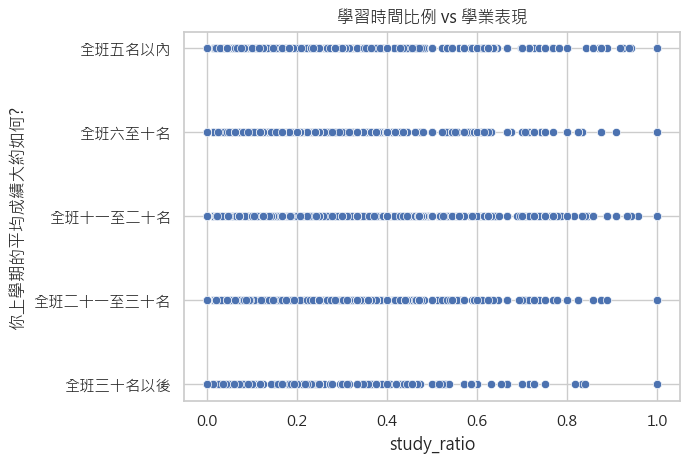

=== 學習時間比例 vs 學業表現 ===
Spearman ρ = nan, p-value = nan
Kendall τ = nan, p-value = nan


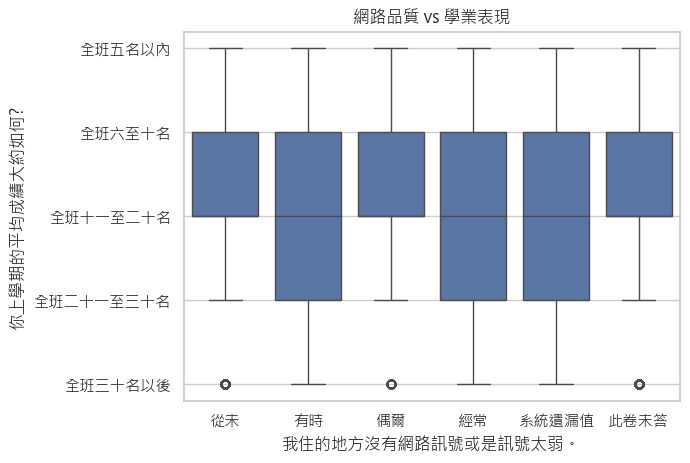


=== 網路品質 vs 學業表現 ===
Spearman ρ = nan, p-value = nan
Kendall τ = nan, p-value = nan


In [24]:
sns.scatterplot(data=df, x='study_ratio', y='你上學期的平均成績大約如何?')
plt.title("學習時間比例 vs 學業表現")
plt.show()


# 1️⃣ 散點圖：學習時間比例 vs 成績
df_corr1 = df[['study_ratio', '你上學期的平均成績大約如何?']].dropna()

# 確保成績是數值型（若不是，需轉換）
df_corr1['成績數值'] = pd.to_numeric(df_corr1['你上學期的平均成績大約如何?'], errors='coerce')

# 移除轉換後的 NaN
df_corr1 = df_corr1.dropna(subset=['成績數值'])

# Spearman
rho1, p_spearman1 = spearmanr(df_corr1['study_ratio'], df_corr1['成績數值'])
# Kendall
tau1, p_kendall1 = kendalltau(df_corr1['study_ratio'], df_corr1['成績數值'])

# 顯示結果
print("=== 學習時間比例 vs 學業表現 ===")
print(f"Spearman ρ = {rho1:.5f}, p-value = {p_spearman1:.5e}")
print(f"Kendall τ = {tau1:.5f}, p-value = {p_kendall1:.5e}")


sns.boxplot(data=df, x='我住的地方沒有網路訊號或是訊號太弱。', y='你上學期的平均成績大約如何?')
plt.title("網路品質 vs 學業表現")
plt.show()

# 2️⃣ 箱型圖：網路品質 vs 成績
df_corr2 = df[['我住的地方沒有網路訊號或是訊號太弱。', '你上學期的平均成績大約如何?']].dropna()

# 成績轉數值
df_corr2['成績數值'] = pd.to_numeric(df_corr2['你上學期的平均成績大約如何?'], errors='coerce')
df_corr2 = df_corr2.dropna(subset=['成績數值'])

# Spearman
rho2, p_spearman2 = spearmanr(df_corr2['我住的地方沒有網路訊號或是訊號太弱。'], df_corr2['成績數值'])
# Kendall
tau2, p_kendall2 = kendalltau(df_corr2['我住的地方沒有網路訊號或是訊號太弱。'], df_corr2['成績數值'])

# 顯示結果
print("\n=== 網路品質 vs 學業表現 ===")
print(f"Spearman ρ = {rho2:.5f}, p-value = {p_spearman2:.5e}")
print(f"Kendall τ = {tau2:.5f}, p-value = {p_kendall2:.5e}")

## 🏫 學校層級支援變項分佈

In [25]:
school_support_cols = ['貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節', '貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等)', '除臺灣學術網路外,本校另行付費提升頻寬', '本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)', '本校的資訊設備借用與管理機制運作完善', '本校能獲得推動數位學習充分的人事或業務費支持', '本校能獲得推動數位學習充分的設備費支持']
print(df[school_support_cols].describe(include='all'))

school_support_cols = [
    '貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節',
    '貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等)',
    '除臺灣學術網路外,本校另行付費提升頻寬',
    '本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)',
    '本校的資訊設備借用與管理機制運作完善',
    '本校能獲得推動數位學習充分的人事或業務費支持',
    '本校能獲得推動數位學習充分的設備費支持'
]

target_col = '你上學期的平均成績大約如何?'

from scipy.stats import spearmanr, kendalltau
import pandas as pd

# 成績轉成數值
df_corr = df[school_support_cols + [target_col]].copy()
df_corr['成績數值'] = pd.to_numeric(df_corr[target_col], errors='coerce')

# 結果迴圈
for col in school_support_cols:
    temp_df = df_corr[[col, '成績數值']].dropna()
    
    # Spearman
    rho, p_spearman = spearmanr(temp_df[col], temp_df['成績數值'])
    
    # Kendall
    tau, p_kendall = kendalltau(temp_df[col], temp_df['成績數值'])

    # 印出結果
    print(f"\n=== {col} × 學業表現 ===")
    print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
    print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")

       貴校目前開設的選修類型的資訊課程(彈性學習時數或加深加廣) 每週共 節  \
count                                 9793   
unique                                  12   
top                                      0   
freq                                  5741   

       貴校有幾個與資訊相關的,常設的社團或代表隊有 個 (資訊相關社團如:資訊社、機器人社、遊戲開發社、數位音樂社、電子競技社、多媒體數位傳播社、手機攝影社、大眾傳播社等)  \
count                                                9793                                    
unique                                                  9                                    
top                                                     1                                    
freq                                                 3188                                    

       除臺灣學術網路外,本校另行付費提升頻寬 本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)  \
count                 9793                                          9793   
unique                   5                                             5   
top                   很不符合                                            

## 🧪 替代分析：不同學校支援程度下 SES 對成績影響

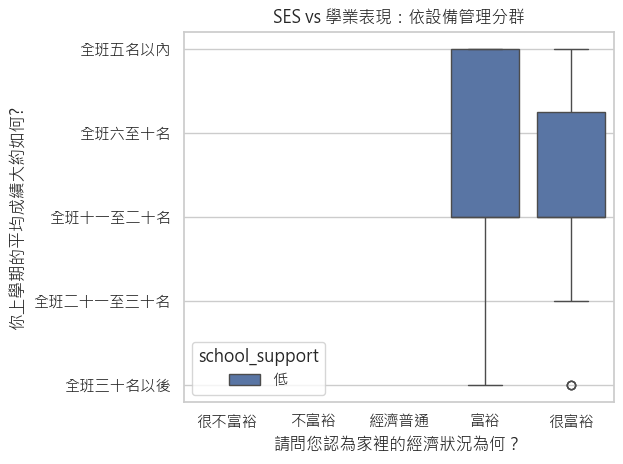


設備管理 高 組的 SES 與學業成績相關性：
Spearman ρ = nan, p-value = nan
Kendall τ = nan, p-value = nan

設備管理 低 組的 SES 與學業成績相關性：
Spearman ρ = nan, p-value = nan
Kendall τ = nan, p-value = nan


In [26]:
# 指定家境順序（從很不富裕到很富裕）
family_order = ['很不富裕', '不富裕', '經濟普通', '富裕', '很富裕']

# 建立有順序的類別型別
family_dtype = CategoricalDtype(categories=family_order, ordered=True)

# 指定順序（不移除任何值）
df['請問您認為家裡的經濟狀況為何？'] = df['請問您認為家裡的經濟狀況為何？'].astype(family_dtype)
df['school_support'] = df['本校的資訊設備借用與管理機制運作完善'].map(lambda x: '高' if x == 1 else '低')

sns.boxplot(data=df, x='請問您認為家裡的經濟狀況為何？', y='你上學期的平均成績大約如何?', hue='school_support')
plt.title("SES vs 學業表現：依設備管理分群")
plt.tight_layout()
plt.show()

# 1. 設定家境的有序類別型態
family_order = ['很不富裕', '不富裕', '經濟普通', '富裕', '很富裕']
family_dtype = CategoricalDtype(categories=family_order, ordered=True)
df['請問您認為家裡的經濟狀況為何？'] = df['請問您認為家裡的經濟狀況為何？'].astype(family_dtype)

# 2. 建立設備管理分群欄位
df['school_support'] = df['本校的資訊設備借用與管理機制運作完善'].map(lambda x: '高' if x == 1 else '低')

# 3. 成績轉成數值（假設成績為文字需轉換）
df['成績數值'] = pd.to_numeric(df['你上學期的平均成績大約如何?'], errors='coerce')

# 5. 等級相關分析，分「高」與「低」兩組分別計算

for group in ['高', '低']:
    subset = df[df['school_support'] == group][['請問您認為家裡的經濟狀況為何？', '成績數值']].dropna()
    # 轉成數字序號方便計算
    subset['家境_數值'] = subset['請問您認為家裡的經濟狀況為何？'].cat.codes

    # Spearman 等級相關
    rho, p_spearman = spearmanr(subset['家境_數值'], subset['成績數值'])
    # Kendall 等級相關
    tau, p_kendall = kendalltau(subset['家境_數值'], subset['成績數值'])

    print(f"\n設備管理 {group} 組的 SES 與學業成績相關性：")
    print(f"Spearman ρ = {rho:.5f}, p-value = {p_spearman:.5e}")
    print(f"Kendall τ = {tau:.5f}, p-value = {p_kendall:.5e}")
